In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/project'
FOLDERNAME = 'nn_test'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(PATH)

%cd $PATH

Mounted at /content/drive
/content/drive/My Drive/nn_test


In [26]:
# Math/deep learning libraries
import numpy as np
import torch
from torch import nn
import pickle

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import itertools

# Data processing
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Progress bars
import tqdm
import random

# Other
import time
from datetime import date

In [ ]:
# Set PyTorch to use the GPU
device = torch.device('cuda')

In [4]:
class MatrixDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, activation):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation)

        for _ in range(num_layers-1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)

        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [6]:
with open('test3_rs_segments.pickle', 'rb') as f:
    segments = pickle.load(f)

In [7]:
with open('test3_rs_bps.pickle', 'rb') as f:
    targets = pickle.load(f)

In [31]:
data_matrix = segments[0:100000, :]
target_vector = targets[0:100000, 0]  # Example target vector

dataset = MatrixDataset(data_matrix, target_vector)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [32]:
subset_indices = random.sample(range(len(train_dataset)), 8000)
small_train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

large_validation_dataset = val_dataset

indices = random.sample(range(len(val_dataset)), 2000)
small_validation_dataset = torch.utils.data.Subset(val_dataset, indices)


In [39]:
def grid_search():
    # data_matrix = segments[0:10000, :]
    # target_vector = targets[0:10000, 0]  # Example target vector

    # dataset = MatrixDataset(data_matrix, target_vector)

    input_size = 200 # len(data_matrix[0])  # Number of input features
    output_size = 1  # Number of output units

    best_losses = {}


    # Define hyperparameters to tune
    optimizers = [optim.SGD]
    learning_rates = [0.0001]
    batch_sizes = [8]
    hidden_sizes = [100]
    num_layers_options = [2]
    activation_functions = [nn.Tanh()]
    num_epochs = 50

    # Generate all possible hyperparameter combinations
    hyperparameter_combinations = itertools.product(optimizers, learning_rates, batch_sizes, hidden_sizes, num_layers_options, activation_functions)

    for hyperparameters in hyperparameter_combinations:
        optimizer_class, learning_rate, batch_size, hidden_size, num_layers, activation = hyperparameters

        model = NeuralNetwork(input_size, hidden_size, output_size, num_layers, activation)

        criterion = nn.MSELoss()
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

        dataloader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
        small_val_dataloader = DataLoader(small_validation_dataset, batch_size=batch_size, shuffle=False)
        large_val_dataloader = DataLoader(large_validation_dataset, batch_size=batch_size, shuffle=False)

        # val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


        for epoch in range(num_epochs):
            train_loss = 0.0
            small_val_loss = 0.0
            large_val_loss = 0.0
            train_losses = []
            val_losses = []
            for batch in dataloader:
                inputs, labels = batch

                optimizer.zero_grad()

                outputs = model(inputs.float())
                loss = criterion(outputs.squeeze(), labels.float())
                loss.backward()
                optimizer.step()

                train_loss += loss.item() #* inputs.size(0)
              
            model.eval()
            with torch.no_grad():
                for batch in small_val_dataloader:
                    inputs, labels = batch

                    outputs = model(inputs.float())
                    loss = criterion(outputs.squeeze(), labels.float())

                    small_val_loss += loss.item() #* inputs.size(0)

                for batch in large_val_dataloader:
                    inputs, labels = batch

                    outputs = model(inputs.float())
                    loss = criterion(outputs.squeeze(), labels.float())

                    large_val_loss += loss.item() #* inputs.size(0)  

            train_loss /= len(dataloader) #/= len(train_dataset)
            small_val_loss /= len(small_val_dataloader)#/= len(val_dataset)
            large_val_loss /= len(large_val_dataloader)


            train_losses.append(train_loss)
            #val_losses.append(val_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Small Val Loss: {small_val_loss}, Large Val Loss: {large_val_loss}")     

        best_losses[hyperparameters] = min(val_losses)   

    return best_losses   


In [ ]:
best_losses = grid_search()

Epoch [1/50], Train Loss: 397.8200512403488, Val Loss: 356.3549371192932
Epoch [2/50], Train Loss: 344.8060323894501, Val Loss: 355.178983984375
Epoch [3/50], Train Loss: 344.61239121603967, Val Loss: 354.60480468673705
Epoch [4/50], Train Loss: 344.6057641729355, Val Loss: 354.5025220123291
Epoch [5/50], Train Loss: 344.3564712032318, Val Loss: 354.7505037132263
Epoch [6/50], Train Loss: 321.97233925876617, Val Loss: 296.2992399124146
Epoch [7/50], Train Loss: 281.75307055244446, Val Loss: 283.0908656616211
Epoch [8/50], Train Loss: 266.18943858366015, Val Loss: 261.9892930326462
Epoch [9/50], Train Loss: 255.67472992789746, Val Loss: 260.8859617946625
Epoch [10/50], Train Loss: 249.57072722625733, Val Loss: 253.94115890388488
Epoch [11/50], Train Loss: 244.4319712805748, Val Loss: 248.9308003162384
Epoch [12/50], Train Loss: 239.9460233649254, Val Loss: 246.9047456911087
Epoch [13/50], Train Loss: 237.14328392801283, Val Loss: 262.85177278175354
Epoch [14/50], Train Loss: 233.3176282480955, Val Loss: 243.36888393993377
Epoch [15/50], Train Loss: 230.32187635512352, Val Loss: 231.99126099243165
Epoch [16/50], Train Loss: 226.8212459525585, Val Loss: 237.14673652267456
Epoch [17/50], Train Loss: 225.00678056583405, Val Loss: 240.41732407569884
Epoch [18/50], Train Loss: 222.7048129172802, Val Loss: 229.78529976959229
Epoch [19/50], Train Loss: 221.64969244832992, Val Loss: 224.94140036849976
Epoch [20/50], Train Loss: 219.02895760755538, Val Loss: 221.69591125583648

In [ ]:
best_losses

{(torch.optim.sgd.SGD, 5e-05, 4, 100, 2, Tanh()): 220.42862635757922,
 (torch.optim.sgd.SGD, 5e-05, 4, 150, 2, Tanh()): 223.55979722115993,
 (torch.optim.sgd.SGD, 5e-05, 8, 100, 2, Tanh()): 230.66835813407897,
 (torch.optim.sgd.SGD, 5e-05, 8, 150, 2, Tanh()): 233.32362754249573,
 (torch.optim.sgd.SGD, 5e-05, 12, 100, 2, Tanh()): 257.1225696220398,
 (torch.optim.sgd.SGD, 5e-05, 12, 150, 2, Tanh()): 261.19646796875,
 (torch.optim.sgd.SGD, 0.0001, 4, 100, 2, Tanh()): 223.67885671454073,
 (torch.optim.sgd.SGD, 0.0001, 4, 150, 2, Tanh()): 239.67031436984539,
 (torch.optim.sgd.SGD, 0.0001, 8, 100, 2, Tanh()): 215.84895410804748,
 (torch.optim.sgd.SGD, 0.0001, 8, 150, 2, Tanh()): 224.85064413261415,
 (torch.optim.sgd.SGD, 0.0001, 12, 100, 2, Tanh()): 219.46310181427003,
 (torch.optim.sgd.SGD, 0.0001, 12, 150, 2, Tanh()): 222.51467427330016,
 (torch.optim.sgd.SGD, 0.0005, 4, 100, 2, Tanh()): 297.80907680444716,
 (torch.optim.sgd.SGD, 0.0005, 4, 150, 2, Tanh()): 293.44154190735816,
 (torch.opti

In [ ]:
import heapq

In [ ]:
save_best_losses = best_losses
# Get the top three entries with lowest values
top_entries = heapq.nsmallest(5, best_losses, key=best_losses.get)

In [ ]:
# Print the top three entries
for entry in top_entries:
    print(entry, best_losses[entry])

(<class 'torch.optim.sgd.SGD'>, 0.0001, 8, 100, 2, Tanh()) 160.53845996856688
(<class 'torch.optim.sgd.SGD'>, 0.0001, 8, 50, 2, Tanh()) 166.0428687133789
(<class 'torch.optim.sgd.SGD'>, 0.0001, 8, 100, 1, Tanh()) 174.8232172241211
(<class 'torch.optim.sgd.SGD'>, 1e-05, 2, 100, 2, Tanh()) 176.93483731678734
(<class 'torch.optim.sgd.SGD'>, 0.0001, 8, 50, 1, Tanh()) 177.9385859375


In [ ]:
# Dictionary of validation losses for different hyperparameter combinations
validation_losses = best_losses

# Plotting validation losses
plt.figure(figsize=(10, 6))
for hyperparameters, losses in validation_losses.items():
    epochs = np.arange(1, len(losses) + 1)
    plt.plot(epochs, losses, label=str(hyperparameters))

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Hyperparameter Combinations')
plt.legend()
plt.tight_layout()
plt.show()

# Get the top three best performing hyperparameter combinations
top_three = sorted(validation_losses.items(), key=lambda x: np.mean(x[1]))[:3]


In [ ]:
top_three

Old Code (not for hyper parameter tuning)

In [ ]:
# Example usage
data_matrix = segments[0:100000, :]
target_vector = targets[0:100000, 0]  # Example target vector

dataset = MatrixDataset(data_matrix, target_vector)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

input_size = len(data_matrix[0])  # Number of input features
hidden_size = 100  # Number of hidden units
output_size = 1  # Number of output units

NameError: ignored

In [ ]:
model = NeuralNetwork(input_size, hidden_size, output_size)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001)

In [ ]:

# Training loop
num_epochs = 40
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for batch in train_dataloader:
        inputs, labels = batch

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch

            outputs = model(inputs.float())
            loss = criterion(outputs.squeeze(), labels.float())

            val_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch [1/40], Train Loss: 128.6367932462072, Val Loss: 39.98491190701723
Epoch [2/40], Train Loss: 35.29578064914607, Val Loss: 39.53787283102125
Epoch [3/40], Train Loss: 33.78789266104661, Val Loss: 36.16951020797901
Epoch [4/40], Train Loss: 30.69703432276845, Val Loss: 32.57808128993213
Epoch [5/40], Train Loss: 28.495124282807346, Val Loss: 30.577103423796594
Epoch [6/40], Train Loss: 26.986643881878535, Val Loss: 29.197034176206962
Epoch [7/40], Train Loss: 25.723612329675724, Val Loss: 27.057057223229855
Epoch [8/40], Train Loss: 24.862789185069037, Val Loss: 26.235991677289643
Epoch [9/40], Train Loss: 24.25343547119985, Val Loss: 25.833746045728773
Epoch [10/40], Train Loss: 23.532081738048607, Val Loss: 24.39468600614667
Epoch [11/40], Train Loss: 22.9867999942065, Val Loss: 23.61282382367179
Epoch [12/40], Train Loss: 22.532422380419636, Val Loss: 23.427034247493744
Epoch [13/40], Train Loss: 22.12025065492354, Val Loss: 22.688687309253215
Epoch [14/40], Train Loss: 21.75174

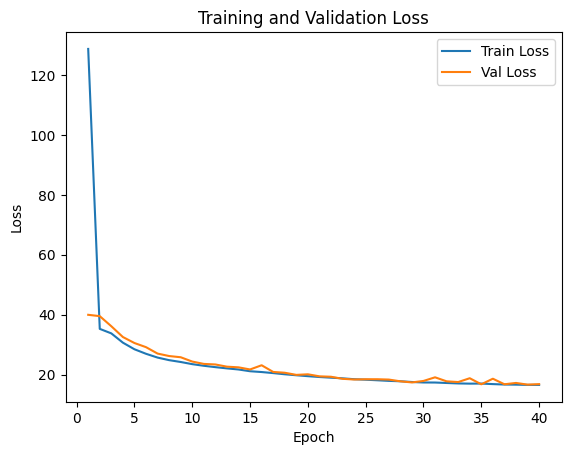

In [ ]:
# Plotting training and validation loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Example inference
# test_input = torch.tensor([[1, 2, 3], [4, 5, 6]])
# with torch.no_grad():
#     predicted_labels = model(test_input.float())

# print("Predicted labels:", predicted_labels.squeeze().tolist())